## Import Dependencies

In [1]:
%load_ext autoreload
%autoreload 2
import pandas as pd
import numpy as np
import transformers
import torch
import shap
import scipy as sp
from tqdm.notebook import tqdm
import scipy
import matplotlib.pyplot as plt
import sys
import os
sys.path.append('../')

## Experiment Setup

Model and Dataset

In [2]:
from utils.models import *
from utils.configs import config, gpt_j_config

# model_name = 'GPT-J'
model_name = 'openllama'
# model_name = 'Llama2'
data_name = 'COS-E'
exp_name = model_name+'_'+data_name

model_config = {
    'GPT-J': gpt_j_config,
}[model_name]
print(model_config)

get_model_function = {
    'GPT-J': get_gpt_j,
    'openllama': get_openllama_auto,
    'Llama2': get_llama2,
}


In [ ]:
from utils.data import get_CommonsenseQA
df = get_CommonsenseQA()

generator, tokenizer = get_model_function[model_name]()
generator.to('cuda:0')

if not os.path.exists(f'../generated_nle/{exp_name}/'):
    os.makedirs(f'../generated_nle/{exp_name}/')

## Get Explanations and SHAP score

### Define Generative functions

In [22]:
from utils.functional import *
from utils.samples import * 
import re

def generate_answers(batched_input_premise, batched_input_choices, batched_input_label, batched_label_idx):
    model_answers_list = []
    for i in range(len(batched_input_premise)):
        prompt = generate_fewshot_prompt_QA(fewshot_QA2_samples, batched_input_premise[i], batched_input_choices[i], batched_input_label[i], batched_label_idx[i])
        input_ids = tokenizer(prompt, return_tensors="pt").input_ids.to(generator.device)
        outputs = generator.generate(
            input_ids=input_ids,
            max_new_tokens=16,
            # do_sample=False,
            pad_token_id=tokenizer.eos_token_id, # to suppress open generation error
            # num_beams=10,
            **model_config['generation_configs'],
            return_dict_in_generate=True,
            output_scores=True,
            # **model_config['generation_configs'],
        )
        model_generated_text = tokenizer.decode(outputs.sequences[0])
        answer = re.findall('Answer: (.*)\n', model_generated_text)[-1].strip('.').lower().replace("'", "") # get the last answer that is answered by the model
        # print(answer)
        try:
            # model_answer = batched_input_choices[i].replace("'", "").split(', ').index(answer)
            model_answer = batched_input_choices[i].strip(';').split('; ').index(answer)
        except:
            model_answer = None
            print(">>>>>>>>>>>>>>model answer not found>>>>>>>>>>>>>>")
            print(model_generated_text)
            print(answer)
            print(i)
        model_answers_list.append(model_answer)
    return model_answers_list

def generate_explanation(batched_input_premise, batched_input_choices, batched_input_label, batched_label_idx):
    nle_list = []
    for i in range(len(batched_input_premise)):
        # trials = model_config['nle_generation']["total_trials"]
        prompt = generate_fewshot_prompt_AE(fewshot_AE2_samples, batched_input_premise[i], batched_input_choices[i], batched_input_label[i], batched_label_idx[i])
        input_ids = tokenizer(prompt, return_tensors="pt").input_ids.to(generator.device)
        outputs = generator.generate(
            input_ids=input_ids,
            max_new_tokens=256,
            # do_sample=False,
            pad_token_id=50256, # to suppress open generation error
            # num_beams=10,
            num_beams=5,
            renormalize_logits=True,
            no_repeat_ngram_size=8, 
            # early_stopping=True,
            return_dict_in_generate=True,
            output_scores=True,
            # **model_config['generation_configs'],
        )
        prompt = tokenizer.decode(outputs.sequences[0])
        final_explanation = re.findall('Explanation: (.*)\n', prompt)[-1]
        nle_list.append(final_explanation)
    return nle_list


### Get NLE

In [ ]:
df = get_CommonsenseQA()
last_df = df.loc[len(df)-10:]
for idx, x in last_df.iterrows():
    print(x['question'])
    print([x[f'choice_{i}'] for i in range(5)])
    print(x.label)
    print()
# print(df.loc[len(df)-10:].question.values)
# print(df.loc[len(df)-10:].values)
# print(df.loc[len(df)-10:].question.values)



small experiments

In [15]:
from utils.samples import *
from utils.functional import *
import re
idx = 45
# prompt = generate_fewshot_prompt_QA_new(fewshot_QAE3_samples_new, batched_input_premise[idx], batched_input_choices[idx], batched_input_label[idx], batched_label_idx[idx])
prompt = generate_fewshot_prompt_QA(fewshot_QA2_samples, batched_input_premise[idx], batched_input_choices[idx], batched_input_label[idx], batched_label_idx[idx])
# prompt = generate_fewshot_prompt_QA_new(fewshot_QA2_samples_new, batched_input_premise[idx], batched_input_choices[idx], batched_input_label[idx], batched_label_idx[idx])

# print(prompt)
input_ids = tokenizer(prompt, return_tensors="pt").input_ids.to(generator.device)
outputs = generator.generate(
    input_ids=input_ids,
    max_new_tokens=128,
    # do_sample=False,
    pad_token_id=tokenizer.eos_token_id, # to suppress open generation error
    # num_beams=10,
    num_beams=5,
    renormalize_logits=True,
    no_repeat_ngram_size=8, 
    early_stopping=True,
    return_dict_in_generate=True,
    output_scores=True,
    # **model_config['generation_configs'],
)
# print(prompt := tokenizer.decode(outputs.sequences[0]))
# print(prompt)
model_generated_text = tokenizer.decode(outputs.sequences[0])
print(model_generated_text)
# answer = re.findall('Answer: (.*)\n', model_generated_text)[-1].strip('.').lower()
# answer = re.findall('Based on Commonsense, the best choice is: (.*)\n', model_generated_text)[-1].strip('.').lower()
# answer = re.findall('The best choice is (.*)\n', model_generated_text)[-1].strip('.').lower()
# answer
# if answer in batched_input_choices[0].split(', '):
# model_answer = batched_input_choices[idx].split(', ').index(answer)
# final_explanation = re.findall('Explanation: (.*)\n', model_generated_text)[-1]
# final_explanation


Question: Where does water in the sky come from?
Choices: space; rain cloud; surface of earth; wishing well; lake or river;
Answer: lake or river

Question: If I wanted to store my chess pawn when I wasn't using it, what would be a good place for that?
Choices: chess set; strategy; toy store; chess game; small case;
Answer: chess set

Please choose the correct answer for the following questions in the same format as the above:

Question: Where would you see people in uniform playing with a ball?
Choices: hole; television; sporting goods store; pool table; sporting event;
Answer: pool table.
<|endoftext|>


Generate Answers

In [23]:
sample_size = 1600
sample_df = df[:sample_size].copy()
sample_df['nle'] = None
batch_size = 160


for i in tqdm(range(0, len(sample_df), batch_size)):
    s_range = range(i, min(i+batch_size, len(sample_df)))
    batched_input_premise = sample_df.question[s_range].tolist()
    # batched_input_choices = create_choices(sample_df.loc[s_range], add_prefix=False)
    # batched_input_choices = create_choices_2(sample_df.loc[s_range], add_prefix=False)
    # batched_input_choices = create_choices_3(sample_df.loc[s_range], add_prefix=False)
    batched_input_choices = create_choices_4(sample_df.loc[s_range], add_prefix=False)

    batched_input_label = make_choice(sample_df.loc[s_range])
    batched_label_idx = [int(sample['label']) for _,sample in sample_df.loc[s_range].iterrows()]
    # break
    
    model_answers_list = generate_answers(
        batched_input_premise, 
        batched_input_choices, 
        batched_input_label,
        batched_label_idx
    )
    sample_df.loc[s_range, 'model_answer'] = model_answers_list
    sample_df.to_csv(f'../generated_nle/{exp_name}/{sample_size}_{min(sample_size, i+batch_size)}_model_answers.csv', index=False)
sample_df

  0%|          | 0/10 [00:00<?, ?it/s]

>>>>>>>>>>>>>>model answer not found>>>>>>>>>>>>>>

Question: Where does water in the sky come from?
Choices: space; rain cloud; surface of earth; wishing well; lake or river;
Answer: lake or river

Question: If I wanted to store my chess pawn when I wasn't using it, what would be a good place for that?
Choices: chess set; strategy; toy store; chess game; small case;
Answer: chess set

Please choose the correct answer for the following questions in the same format as the above:

Question: What home entertainment equipment requires cable?
Choices: radio shack; substation; cabinet; television; desk;
Answer: cable.
<|endoftext|>
cable
4
>>>>>>>>>>>>>>model answer not found>>>>>>>>>>>>>>

Question: Where does water in the sky come from?
Choices: space; rain cloud; surface of earth; wishing well; lake or river;
Answer: lake or river

Question: If I wanted to store my chess pawn when I wasn't using it, what would be a good place for that?
Choices: chess set; strategy; toy store; chess game; 

,id,question,choice_0,choice_1,choice_2,choice_3,choice_4,label,human_expl_open-ended,nle,model_answer
0,075e483d21c29a511267ef62bedc0461,The sanctions against the school were a punish...,ignore,enforce,authoritarian,yell at,avoid,0,Not sure what else could be a common ground,None,1
1,61fe6e879ff18686d7552425a36344c8,Sammy wanted to go to where the people were. ...,race track,populated areas,the desert,apartment,roadblock,1,People will be in populated areas.,None,3
2,02e821a3e53cb320790950aab4489e85,Google Maps and other highway and street GPS s...,united states,mexico,countryside,atlas,oceans,3,atlases were collections of highway and street...,None,3
3,23505889b94e880c3e89cff4ba119860,"The fox walked from the city into the forest, ...",pretty flowers.,hen house,natural habitat,storybook,dense forest,2,Usually the habitat of a fox is forest and it ...,None,0
4,e8a8b3a2061aa0e6d7c6b522e9612824,What home entertainment equipment requires cable?,radio shack,substation,cabinet,television,desk,3,television is the only option that is a home e...,None,None
...,...,...,...,...,...,...,...,...,...,...,...
1595,709912a9876e824ea97da15170fd1716,Where might you have to pay for a shopping bag...,restaurant,closet,at starbucks,supermarket,home,3,A supermarket is the only place one would need...,None,3
1596,95703127228d8b87b3fe998b1b2203e6,Where would the Air Force keep an airplane?,airport terminal,military base,sky,hanger,airplane hangar,1,is the best since it is the best backup,None,4
1597,f7216534fcff2743cc94c29cb689ea71,What is a computer terminal?,electrical device,battery,electronics,transportation system,initial,0,An computer is an electrical device connected ...,None,0
1598,374e8dc01ca7749d668ed66ac4044e70,"She was known for be soft and sensitive, but w...",non sensitive,resistant,stoic,hardened,uncaring,2,Soft and senstive persons aren't expected to b...,None,4


Generate Explanation from Model Answers

In [24]:
sample_df = pd.read_csv(f"../generated_nle/{exp_name}/1600_1600_model_answers.csv")
batch_size = 160
for i in tqdm(range(0, len(sample_df), batch_size)):
    s_range = range(i, min(i+batch_size, len(sample_df)))
    batch_samples = sample_df.loc[i:i+batch_size-1]
    has_answer = ~batch_samples['model_answer'].isna()
    batch_samples = batch_samples[has_answer]
    batched_input_premise = batch_samples.question.tolist()
    batched_input_choices = create_choices_2(batch_samples, add_prefix=False)
    batched_input_label = make_choice(batch_samples)
    batched_label_idx = [int(sample['model_answer']) for _,sample in batch_samples.iterrows()]

    list_nle = generate_explanation(
        batched_input_premise, 
        batched_input_choices, 
        batched_input_label,
        batched_label_idx
    )
    valid_range = np.array(s_range)[has_answer]
    sample_df.loc[valid_range, 'nle'] = list_nle
    sample_df.to_csv(f'../generated_nle/{exp_name}/{sample_size}_{min(sample_size, i+batch_size)}_model_answer_nle.csv', index=False)
sample_df.head()

  0%|          | 0/10 [00:00<?, ?it/s]

,id,question,choice_0,choice_1,choice_2,choice_3,choice_4,label,human_expl_open-ended,nle,model_answer
0,075e483d21c29a511267ef62bedc0461,The sanctions against the school were a punish...,ignore,enforce,authoritarian,yell at,avoid,0,Not sure what else could be a common ground,The school's efforts to change were not enough...,1.0
1,61fe6e879ff18686d7552425a36344c8,Sammy wanted to go to where the people were. ...,race track,populated areas,the desert,apartment,roadblock,1,People will be in populated areas.,Sammy could go to a bustling city like Los Ang...,3.0
2,02e821a3e53cb320790950aab4489e85,Google Maps and other highway and street GPS s...,united states,mexico,countryside,atlas,oceans,3,atlases were collections of highway and street...,Google Maps and other highway and city GPS ser...,3.0
3,23505889b94e880c3e89cff4ba119860,"The fox walked from the city into the forest, ...",pretty flowers.,hen house,natural habitat,storybook,dense forest,2,Usually the habitat of a fox is forest and it ...,The fox was looking for a place in the forest ...,0.0
4,e8a8b3a2061aa0e6d7c6b522e9612824,What home entertainment equipment requires cable?,radio shack,substation,cabinet,television,desk,3,television is the only option that is a home e...,NaN,NaN


In [85]:
file_name = "model_answer_nle"
sample_df = pd.read_csv(f'../generated_nle/{exp_name}/1600_1600_{file_name}.csv')
sample_size = len(sample_df)
sample_df = sample_df.dropna(subset=['nle'])
def has_period(text):
    ret = []
    for i, x in enumerate(text):
        if type(x) == float:
            print(i, x)
        ret.append("." in x[-10:])
    return np.array(ret)
invalid_condition = sample_df['nle'].str.contains('a chess set') | False==has_period(sample_df['nle'])
valid_samples = sample_df[~invalid_condition]
# sample_df = valid_samples
# sample_df = sample_df.reset_index(drop=True)
valid_samples.to_csv(f'../generated_nle/{exp_name}/valid_samples_{sample_size}_{file_name}.csv', index=False)
valid_samples

array([0, 1, 2, 3, 5, 6, 7, 8, 9])

### Generate SHAP values 

In [8]:
get_model_function

{'GPT-J': <function utils.models.get_gpt_j()>,
 'opemllama': <function utils.models.get_openllama_auto(model_path='openlm-research/open_llama_3b')>}

In [26]:
model = generator

In [3]:
model, tokenizer = get_model_function[exp_name.split('_')[0]]()
model.to('cuda:0')

GPTJForCausalLM(
  (transformer): GPTJModel(
    (wte): Embedding(50400, 4096)
    (drop): Dropout(p=0.0, inplace=False)
    (h): ModuleList(
      (0-27): 28 x GPTJBlock(
        (ln_1): LayerNorm((4096,), eps=1e-05, elementwise_affine=True)
        (attn): GPTJAttention(
          (attn_dropout): Dropout(p=0.0, inplace=False)
          (resid_dropout): Dropout(p=0.0, inplace=False)
          (k_proj): Linear(in_features=4096, out_features=4096, bias=False)
          (v_proj): Linear(in_features=4096, out_features=4096, bias=False)
          (q_proj): Linear(in_features=4096, out_features=4096, bias=False)
          (out_proj): Linear(in_features=4096, out_features=4096, bias=False)
        )
        (mlp): GPTJMLP(
          (fc_in): Linear(in_features=4096, out_features=16384, bias=True)
          (fc_out): Linear(in_features=16384, out_features=4096, bias=True)
          (act): NewGELUActivation()
          (dropout): Dropout(p=0.0, inplace=False)
        )
      )
    )
    (ln_f)

In [4]:
# set model decoder to true
model.config.is_decoder=True
# set text-generation params under task_specific_params
#  eos_token_id=50256, 
# full_text=False
# gen_dict = {
#     "do_sample": True,
#     "max_length": 50,
#     "temperature": 0.7,
#     "top_k": 50,
#     "no_repeat_ngram_size": 2
# }

gen_dict = dict(
    max_new_tokens=16,
    # do_sample=False,
    pad_token_id=tokenizer.eos_token_id, # to suppress open generation error
    **model_config['generation_configs'],
)
model.config.task_specific_params = dict()
model.config.task_specific_params["text-generation"] = gen_dict

In [ ]:
from utils.functional import *
from utils.samples import*
df = pd.read_csv(f'../generated_nle/{exp_name}/valid_samples_1600_model_answer_nle.csv')

limit = len(df)
df = df.loc[:limit].copy()

import warnings
# warnings.resetwarnings()
warnings.filterwarnings("ignore")

shap_model = shap.models.TeacherForcing(model, tokenizer)
masker = shap.maskers.Text(tokenizer, mask_token="...", collapse_mask_token=True)

top_k=3
batch_size = 160
for i in tqdm(range(0, limit, batch_size)):
    s_range = np.array(range(i, min(i+batch_size, limit)))
    batched_input_premise = df.question[s_range].tolist()
    batched_input_choices = create_choices_2(df.loc[s_range], add_prefix=False)
    batched_input_label = make_choice(df.loc[s_range])
    batched_label_idx = [int(sample['label']) for _,sample in df.loc[s_range].iterrows()]

    shap_value_list = []
    for j in range(len(batched_input_premise)):
        explainer = shap.Explainer(shap_model, masker)
        prompt = generate_fewshot_prompt_QA(fewshot_QA2_samples, batched_input_premise[j], batched_input_choices[j], batched_input_label[j], batched_label_idx[j])
        input_ids = tokenizer(prompt, return_tensors="pt").input_ids.to(model.device)
        model_outputs = model.generate(
            # input_ids=input_ids,
            # max_new_tokens=16,
            # # do_sample=False,
            # pad_token_id=tokenizer.eos_token_id, # to suppress open generation error
            # # num_beams=10,
            # num_beams=5,
            # renormalize_logits=True,
            # no_repeat_ngram_size=8, 
            # return_dict_in_generate=True,
            # output_scores=True,

            input_ids=input_ids,
            max_new_tokens=16,
            # do_sample=False,
            pad_token_id=50256, # to suppress open generation error
            # num_beams=10,
            num_beams=5,
            renormalize_logits=True,
            # no_repeat_ngram_size=8, 
            # early_stopping=True,
            return_dict_in_generate=True,
            output_scores=True,
            # **model_config['generation_configs'],
        )
        model_generated_text = tokenizer.decode(model_outputs.sequences[0])
        # break
        shap_values = explainer([prompt])

        # instance = shap_values[0,:]
        # pos_vals = instance.values[instance.values>0]
        # max_n = np.argsort(pos_vals)[-top_k:]
        # max_sum = pos_vals[max_n].sum()
        text_data = shap_values.data[0]
        # start position for gpt-j, which is the token after the : of question, which is the +2 
        question_start = np.arange(len(text_data))[np.where(text_data == "Question")].max() + 2
        quesiton_end = np.arange(len(text_data))[np.where(text_data == "Cho")].max()
        question = text_data[question_start:quesiton_end-2]
        # print(question)
        question_shap = shap_values.values[0][question_start:quesiton_end-2]
        question_shap_yes = question_shap[..., :-1]
        # avg_shap = (question_shap_yes>0).mean()
        question_shap_yes[question_shap_yes<0] = 0
        pos_question_shap_yes = question_shap_yes.sum(-1)
        ind = np.argpartition(pos_question_shap_yes, -top_k)[-top_k:]
        max_shap = pos_question_shap_yes.mean()
        print(max_shap)

        shap_value_list.append(max_shap)
        # print(question_shap)
        # print(question_shap_yes)
        # print((question_shap_yes>0).mean())
        # question_shap_selected = 
        # positive_shap = np.mean(question_shap[..., 0])
        # positive_shap = np.mean(question_shap>0)
        # break
    # break

    df.loc[s_range, f'max_shap_value'] = shap_value_list
    df.to_csv(f'../generated_nle/{exp_name}/{data_name}_{limit}_{s_range.max()}_shap.csv', index=False)
    # print(len(sample.question.split(" ")))
    # print(positive_shap)
    # break

# df.to_csv(f'../generated_nle/GPT-J_COS-E/COS-E_{limit}_shap.csv', index=False)
# candidate_labels

In [16]:
question_shap_yes[question_shap_yes<0] = 0
question_shap_yes = question_shap_yes.sum(-1)

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0.])

In [4]:
data_name 

'COS-E'

(array([ 37.,   1.,  13.,  12.,  12.,  38.,  46.,  49.,  49.,  56., 164.,
        119.,  98., 175., 101., 150., 115.,  84.,  38., 178.]),
 array([0.  , 0.05, 0.1 , 0.15, 0.2 , 0.25, 0.3 , 0.35, 0.4 , 0.45, 0.5 ,
        0.55, 0.6 , 0.65, 0.7 , 0.75, 0.8 , 0.85, 0.9 , 0.95, 1.  ]),
 <BarContainer object of 20 artists>)

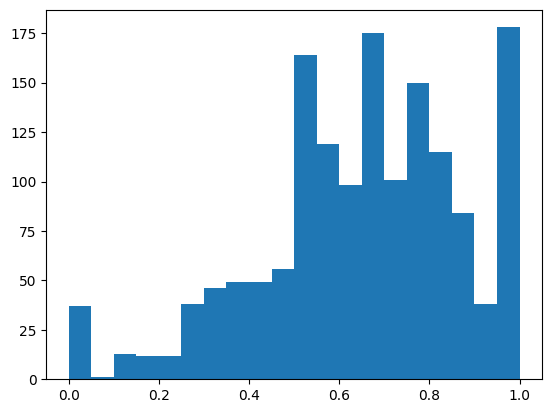

In [9]:
df = pd.read_csv(f"../generated_nle/GPT-J_COS-E/{data_name}_1535_1534_shap.csv")
import matplotlib.pyplot as plt
plt.hist(df['max_shap_value'], bins=20)

In [56]:
output_names = shap_values.output_names
output_names

["'", 'avoid', "'", '']

In [33]:
question_shap

array([[ 0.25499835,  0.51300572,  0.29760383],
       [ 0.25499835,  0.51300572,  0.29760383],
       [-0.11267167, -0.00426063, -0.16047739],
       [-0.11267167, -0.00426063, -0.16047739],
       [-0.10597808, -0.01795445, -0.1006442 ],
       [-0.10597808, -0.01795445, -0.1006442 ],
       [ 0.15497902, -0.11018095, -0.09814789],
       [ 0.15497902, -0.11018095, -0.09814789],
       [ 0.15497902, -0.11018095, -0.09814789],
       [ 0.2207055 , -0.27186382, -0.14738744],
       [-0.11896509,  0.06768506,  0.08170149],
       [-0.11896509,  0.06768506,  0.08170149],
       [-0.11896509,  0.06768506,  0.08170149],
       [-0.11896509,  0.06768506,  0.08170149],
       [-0.11896509,  0.06768506,  0.08170149],
       [-0.64676863,  0.03660306, -0.19551068],
       [-0.64676863,  0.03660306, -0.19551068],
       [-0.21998275,  0.06297155, -0.67343732],
       [-0.19320152,  0.03467226, -0.8519333 ],
       [ 0.07975562, -0.19418687, -0.13615681],
       [ 0.07975562, -0.19418687, -0.136

In [11]:
shap.plots.text(shap_values)

## Training for the Probe

### Load Model

In [3]:
bert_model = transformers.pipeline('sentiment-analysis', top_k=None)
tokenizer = bert_model.tokenizer
sample_input = tokenizer(['heavy metal'])

No model was supplied, defaulted to distilbert-base-uncased-finetuned-sst-2-english and revision af0f99b (https://huggingface.co/distilbert-base-uncased-finetuned-sst-2-english).
Using a pipeline without specifying a model name and revision in production is not recommended.


### Get Data

In [4]:
# get the content between brackets
def get_bracket_content(s):
    return re.findall(r'\((.*?)\)', s)[0]

In [12]:
import ast
import re
# sample_df = pd.read_csv("../generated_nle/GPT-J_COS-E/COS-E_505_shap.csv")
file_prefix = 'COS-E_1535_1534'
file_prefix = 'COS-E_1525_1524'
sample_df = pd.read_csv(f"../generated_nle/GPT-J_COS-E/{file_prefix}_shap.csv")
# supplements = ["../COS-E_range(0, 1797)_shap.csv", "../COS-E_range(1797, 3594)_shap.csv"]
# final_df_len = 0
# for fname in supplements:
#     # range_tuple = re.findall(r'\((.*?)\)', fname)[0].split(', ')
#     # range_tuple = [int(x) for x in range_tuple]
#     if sample_df is None:
#         sample_df = pd.read_csv(fname)
#     else:
#         sample_df = pd.concat([sample_df, pd.read_csv(fname)], ignore_index=True)  
sample_df

,id,question,choice_0,choice_1,choice_2,choice_3,choice_4,label,human_expl_open-ended,nle,model_answer,max_shap_value
0,075e483d21c29a511267ef62bedc0461,The sanctions against the school were a punish...,ignore,enforce,authoritarian,yell at,avoid,0,Not sure what else could be a common ground,The school's efforts to change were not enough...,1.0,0.103508
1,61fe6e879ff18686d7552425a36344c8,Sammy wanted to go to where the people were. ...,race track,populated areas,the desert,apartment,roadblock,1,People will be in populated areas.,Sammy could go to a bustling city like Los Ang...,3.0,0.573467
2,02e821a3e53cb320790950aab4489e85,Google Maps and other highway and street GPS s...,united states,mexico,countryside,atlas,oceans,3,atlases were collections of highway and street...,Google Maps and other highway and city GPS ser...,3.0,0.468380
3,23505889b94e880c3e89cff4ba119860,"The fox walked from the city into the forest, ...",pretty flowers.,hen house,natural habitat,storybook,dense forest,2,Usually the habitat of a fox is forest and it ...,The fox was looking for a place in the forest ...,0.0,0.116490
4,3d0f8824ea83ddcc9ab03055658b89d3,"The forgotten leftovers had gotten quite old, ...",carpet,refrigerator,breadbox,fridge,coach,1,Becuase Leftovers are put in the fridge,The forgotten leftovers had gotten old and cov...,4.0,0.213541
...,...,...,...,...,...,...,...,...,...,...,...,...
1512,709912a9876e824ea97da15170fd1716,Where might you have to pay for a shopping bag...,restaurant,closet,at starbucks,supermarket,home,3,A supermarket is the only place one would need...,You can buy a shopping bag at a supermarket.,3.0,0.145242
1513,95703127228d8b87b3fe998b1b2203e6,Where would the Air Force keep an airplane?,airport terminal,military base,sky,hanger,airplane hangar,1,is the best since it is the best backup,The Air Force would keep an airplane at a mili...,4.0,1.053180
1514,f7216534fcff2743cc94c29cb689ea71,What is a computer terminal?,electrical device,battery,electronics,transportation system,initial,0,An computer is an electrical device connected ...,A computer terminal is an electrical device us...,0.0,0.183056
1515,374e8dc01ca7749d668ed66ac4044e70,"She was known for be soft and sensitive, but w...",non sensitive,resistant,stoic,hardened,uncaring,2,Soft and senstive persons aren't expected to b...,The stoic person was known for being strong an...,4.0,0.237869


In [23]:
bert_model.model

DistilBertForSequenceClassification(
  (distilbert): DistilBertModel(
    (embeddings): Embeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (transformer): Transformer(
      (layer): ModuleList(
        (0-5): 6 x TransformerBlock(
          (attention): MultiHeadSelfAttention(
            (dropout): Dropout(p=0.1, inplace=False)
            (q_lin): Linear(in_features=768, out_features=768, bias=True)
            (k_lin): Linear(in_features=768, out_features=768, bias=True)
            (v_lin): Linear(in_features=768, out_features=768, bias=True)
            (out_lin): Linear(in_features=768, out_features=768, bias=True)
          )
          (sa_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (ffn): FFN(
            (dropout): Dropout(p=0.1, inplace=False)
 

In [31]:
## define a torch lstm model
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from functools import partial
from transformers import AutoTokenizer

device = torch.device('cuda:0')

## use a tokenizer from the bert model
bert_model = transformers.pipeline('sentiment-analysis', top_k=None)

class Distilbert_LSTM_regressor(nn.Module):
    def __init__(self, input_size=768, hidden_size=256, num_layers=3, bidirectional=True):
        super().__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        # self.bert_model = bert_model
        self.embedding = bert_model.model.distilbert.eval()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True, bidirectional=bidirectional)
        out_size = hidden_size * 2 if bidirectional else hidden_size
        self.fc = nn.Linear(out_size, 1)
        self.double()
    def forward(self, x):
        with torch.no_grad():
            bert_embeddings = self.embedding(**x)
        self.lstm.flatten_parameters()
        out, _ = self.lstm(bert_embeddings.last_hidden_state)
        out = self.fc(out[:, -1, :])
        return out

class LSTM_regressor(nn.Module):
    def __init__(self, input_size=768, hidden_size=256, num_layers=3, bidirectional=True):
        super().__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.embedding = nn.Embedding(50265, input_size)
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True, bidirectional=bidirectional)
        out_size = hidden_size * 2 if bidirectional else hidden_size
        self.fc = nn.Linear(out_size, 1)
        self.double()
    def forward(self, x):
        embeddings = self.embedding(x)
        self.lstm.flatten_parameters()
        out, _ = self.lstm(embeddings)
        out = self.fc(out[:, -1, :])
        return out
        
class Sentiment_Dataset(torch.utils.data.Dataset):
    def __init__(self, df, tokenizer):
        self.df = df
        self.max_len = tokenizer.model_max_length
    def __len__(self):
        return len(self.df)
    def __getitem__(self, idx):
        nle_input = self.df.nle[idx]
        label = self.df.max_shap_value[idx]
        return nle_input, label  

# def collate_fn_base(data, tokenizer):
#     nle_input, label = zip(*data)
#     nle_input = tokenizer(nle_input, return_tensors="pt", padding=True)
#     nle_input = {k: v.to(device) for k, v in nle_input.items()}
#     return nle_input, torch.tensor(label).to(device).reshape(-1,1)

def collate_fn_base(data, tokenizer):
    nle_input, label = zip(*data)
    nle_input = tokenizer(nle_input, return_tensors="pt", padding=True)
    nle_input = nle_input.input_ids.to(device)
    return nle_input, torch.tensor(label).to(device).reshape(-1,1)

# model = Distilbert_LSTM_regressor().to(device)
model = LSTM_regressor().to(device)

# tokenizer = bert_model.tokenizer
tokenizer = AutoTokenizer.from_pretrained('nlpcloud/instruct-gpt-j-fp16')
tokenizer.pad_token = tokenizer.eos_token
collate_fn = partial(collate_fn_base, tokenizer=tokenizer)

train_size = int(0.7 * len(sample_df))
val_size = int(0.15 * len(sample_df))

np.random.seed(42)
idxes = np.random.permutation(len(sample_df))

train_idxes, val_idxes, test_idxes = idxes[:train_size], idxes[train_size:train_size+val_size], idxes[train_size+val_size:]
train_dataset = Sentiment_Dataset(sample_df.loc[train_idxes, :].copy().reset_index(), tokenizer)
val_dataset = Sentiment_Dataset(sample_df.loc[val_idxes, :].copy().reset_index(), tokenizer)
test_dataset = Sentiment_Dataset(sample_df.loc[test_idxes, :].copy().reset_index(), tokenizer)

batch_size = 32
train_dataloader = DataLoader(train_dataset, 
    batch_size=batch_size, shuffle=True, num_workers=0, collate_fn=collate_fn)
val_dataloader = DataLoader(val_dataset,
    batch_size=batch_size, shuffle=False, num_workers=0, collate_fn=collate_fn)
test_dataloader = DataLoader(test_dataset,
    batch_size=batch_size, shuffle=False, num_workers=0, collate_fn=collate_fn)
## collate function doesnt work with n workers > 0?

criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
# optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)

print(len(train_dataset), len(val_dataset), len(test_dataset))


No model was supplied, defaulted to distilbert-base-uncased-finetuned-sst-2-english and revision af0f99b (https://huggingface.co/distilbert-base-uncased-finetuned-sst-2-english).
Using a pipeline without specifying a model name and revision in production is not recommended.


1061 227 229


In [32]:
# best_val_loss = np.inf
best_peasonr = -np.inf
for epoch in (ep_disc:=tqdm(range(n_epochs:=32))):
    model.train()
    y_true, y_pred, train_loss = [], [], []
    for (xs, ys) in train_dataloader:
        model.zero_grad()
        out = model(xs)
        loss = criterion(out, ys)
        train_loss.append(loss.item())
        loss.backward()
        optimizer.step()
        y_true.append(ys.detach().cpu().numpy().flatten())
        y_pred.append(out.detach().cpu().numpy().flatten())
    y_true, y_pred = np.concatenate(y_true), np.concatenate(y_pred)
    train_loss = np.mean(train_loss)
    train_PearsonR = scipy.stats.pearsonr(y_pred, y_true)[0]

    model.eval()
    y_true, y_pred, val_loss = [], [], []
    for (xs, ys) in val_dataloader:
        with torch.no_grad():
            out = model(xs)
        y_true.append(ys.cpu().numpy().flatten())
        y_pred.append(out.cpu().numpy().flatten())
        loss = criterion(out, ys)
        val_loss.append(loss.item())
    val_loss = np.mean(val_loss)
    y_true, y_pred = np.concatenate(y_true), np.concatenate(y_pred)
    PearsonR = scipy.stats.pearsonr(y_pred, y_true)[0]
    print(f'epoch: {epoch}, train_loss {train_loss:.3f}, PearsonR: {train_PearsonR:.3f}, val_loss: {val_loss:.3f}, PearsonR: {PearsonR:.3f}')
    if PearsonR > best_peasonr:
        best_peasonr = PearsonR
        torch.save(model.state_dict(), f'../generated_nle/{exp_name}/{file_prefix}_best_model.pth')
        print('saved best model')

  0%|          | 0/32 [00:00<?, ?it/s]

epoch: 0, train_loss 0.475, PearsonR: -0.099, val_loss: 0.241, PearsonR: -0.011
saved best model
epoch: 1, train_loss 0.449, PearsonR: -0.002, val_loss: 0.242, PearsonR: -0.017
epoch: 2, train_loss 0.444, PearsonR: 0.016, val_loss: 0.246, PearsonR: -0.028
epoch: 3, train_loss 0.450, PearsonR: -0.010, val_loss: 0.239, PearsonR: 0.012
saved best model
epoch: 4, train_loss 0.453, PearsonR: -0.033, val_loss: 0.241, PearsonR: -0.059
epoch: 5, train_loss 0.445, PearsonR: 0.018, val_loss: 0.242, PearsonR: -0.048
epoch: 6, train_loss 0.449, PearsonR: -0.001, val_loss: 0.241, PearsonR: -0.011
epoch: 7, train_loss 0.443, PearsonR: 0.054, val_loss: 0.244, PearsonR: -0.050
epoch: 8, train_loss 0.444, PearsonR: 0.024, val_loss: 0.242, PearsonR: -0.040
epoch: 9, train_loss 0.445, PearsonR: 0.032, val_loss: 0.247, PearsonR: -0.007
epoch: 10, train_loss 0.451, PearsonR: 0.058, val_loss: 0.246, PearsonR: -0.006
epoch: 11, train_loss 0.445, PearsonR: 0.027, val_loss: 0.250, PearsonR: -0.031
epoch: 12, t

In [ ]:

datasets_dict = {
    'train': train_dataset,
    'val': val_dataset,
    'test': test_dataset
}

model.load_state_dict(torch.load(f'../generated_nle/{exp_name}/{file_prefix}_best_model.pth'))
model.eval()

import ipywidgets as widgets
@widgets.interact(split=['train', 'val', 'test'])
def eval_for_datast(split):
    some_dataset = datasets_dict[split]
    some_dataloader = DataLoader(some_dataset,
        batch_size=batch_size, shuffle=False, num_workers=0, collate_fn=collate_fn)
    y_pred, y_true, xs_len = [], [], []
    for (xs, ys) in (disc:=tqdm(some_dataloader)):
        with torch.no_grad():
            out = model(xs)
        y_pred.append(out.cpu().numpy())
        y_true.append(ys.cpu().numpy())
        # disc.set_description(f'loss: {loss.item():.3f}')
    y_pred = np.vstack(y_pred).flatten()
    y_true = np.vstack(y_true).flatten()
    MAE = np.abs(y_pred - y_true)
    sent_len = [len(x.split(" ")) for x in some_dataset.df.question]
    PearsonR = scipy.stats.pearsonr(y_pred, y_true)
    Loss = criterion(torch.tensor(y_pred), torch.tensor(y_true)).item()
    print(f'PearsonR: {PearsonR[0]:.3f}, p-value: {PearsonR[1]:.3f}, loss: {Loss:.3f}')
    plt.scatter(y_pred, y_true, alpha=0.5)
    plt.xlabel('predicted')
    plt.ylabel('actual')
    plt.show()  
    PearsonR = scipy.stats.pearsonr(sent_len, MAE)
    print(f'PearsonR: {PearsonR[0]:.3f}') 
    plt.scatter(sent_len, MAE, alpha=0.5)
    plt.show()
    @widgets.interact(idx=(0, len(some_dataset)-1))
    def show_sample(idx):
        x, y = some_dataset[idx]
        nle = tokenizer(x, return_tensors="pt", padding=True)
        nle = {k: v.to(device) for k, v in nle.items()}
        model.eval()
        with torch.no_grad():
            out = model(nle)
        # out, sample_df.max_shap_value[0]
        print(f'predicted: {out.item():.3f}, actual: {y:.3f}')
        print(f'input: {x}')


interactive(children=(Dropdown(description='split', options=('train', 'val', 'test'), value='train'), Output()…

: 

In [ ]:
# get max numbers